### 🔊 Penjelasan Fungsi Augmentasi Audio

#### `noise(data)`
Menambahkan noise (derau) acak ke dalam sinyal audio.  
**Tujuan:** Membantu model menjadi lebih robust terhadap noise di lingkungan nyata.  
**Cara kerja:** Menambahkan noise Gaussian skala kecil ke setiap sampel audio.

#### `shift(data)`
Menggeser sinyal audio ke depan atau ke belakang dalam domain waktu.  
**Tujuan:** Meniru variasi waktu ucapan yang bisa terjadi secara alami.  
**Cara kerja:** Menggunakan `np.roll` untuk memindahkan data sepanjang sumbu waktu.

#### `stretch(data, rate=0.8)`
Melakukan time-stretching terhadap audio tanpa mengubah pitch-nya.  
**Tujuan:** Melatih model untuk mengenali ucapan lebih cepat atau lambat dari biasanya.  
**Cara kerja:** Menggunakan `librosa.effects.time_stretch` dengan `rate` tertentu.

#### `pitch(data, sample_rate)`
Mengubah pitch audio tanpa mempengaruhi durasi.  
**Tujuan:** Meniru variasi frekuensi suara dari pembicara yang berbeda.  
**Cara kerja:** Menggunakan `librosa.effects.pitch_shift` untuk menaikkan atau menurunkan nada.

#### `dyn_change(data)`
Mengubah dinamika volume sinyal audio.  
**Tujuan:** Membantu model belajar dari data dengan variasi intensitas suara yang berbeda.  
**Cara kerja:** Mengalikan sinyal dengan faktor skala acak.

#### `speedNpitch(data)`
Mengubah kecepatan dan pitch secara bersamaan.  
**Tujuan:** Meningkatkan keragaman data dengan modifikasi gabungan antara durasi dan nada.  
**Cara kerja:** Menggunakan interpolasi untuk mempercepat atau memperlambat sinyal, lalu menyamakan panjang dengan sinyal asli.


In [1]:
import os
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook
import soundfile as sf

In [2]:
# Konfigurasi
DATASET_PATH = "dataset"
COMMANDS = ["baca", "berhenti", "foto", "halo", "info", "kembali", "ulang"]

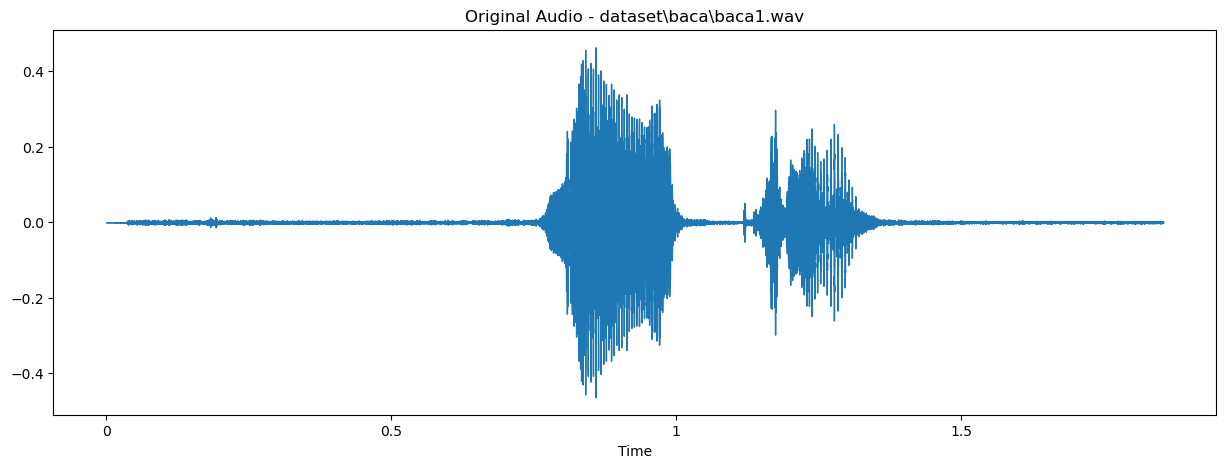

In [3]:
#Audio Original

sample_command = "baca"
sample_file = os.path.join(DATASET_PATH, sample_command, os.listdir(os.path.join(DATASET_PATH, sample_command))[0])
data, sampling_rate = librosa.load(sample_file, sr=None)

# Tampilkan waveform dan play audio
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title(f"Original Audio - {sample_file}")
plt.show()

# Play audio
ipd.Audio(data, rate=sampling_rate)

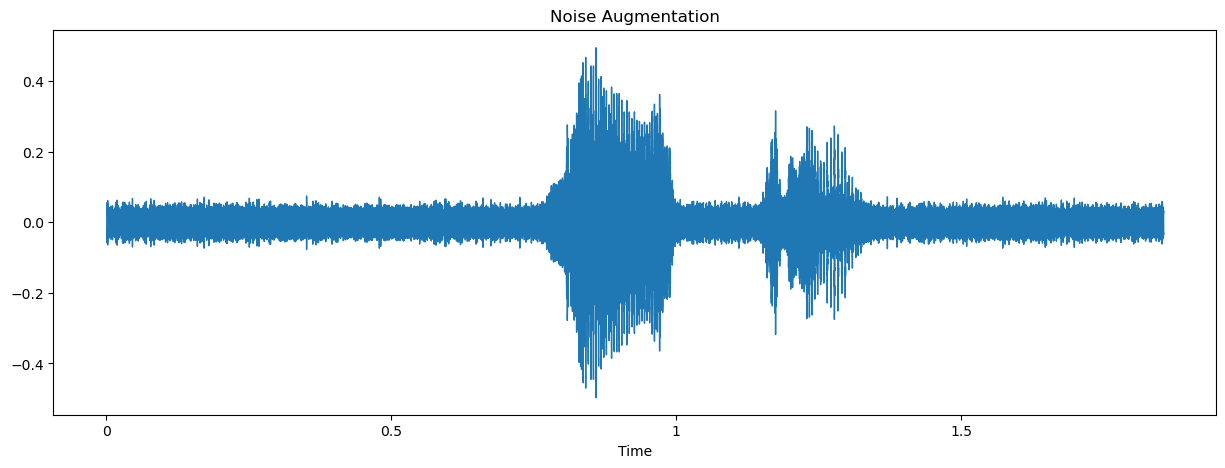

In [4]:
def noise(data):
    noise_amp = 0.05 * np.random.uniform() * np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

# Apply
x = noise(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
plt.title("Noise Augmentation")
plt.show()
ipd.Audio(x, rate=sampling_rate)

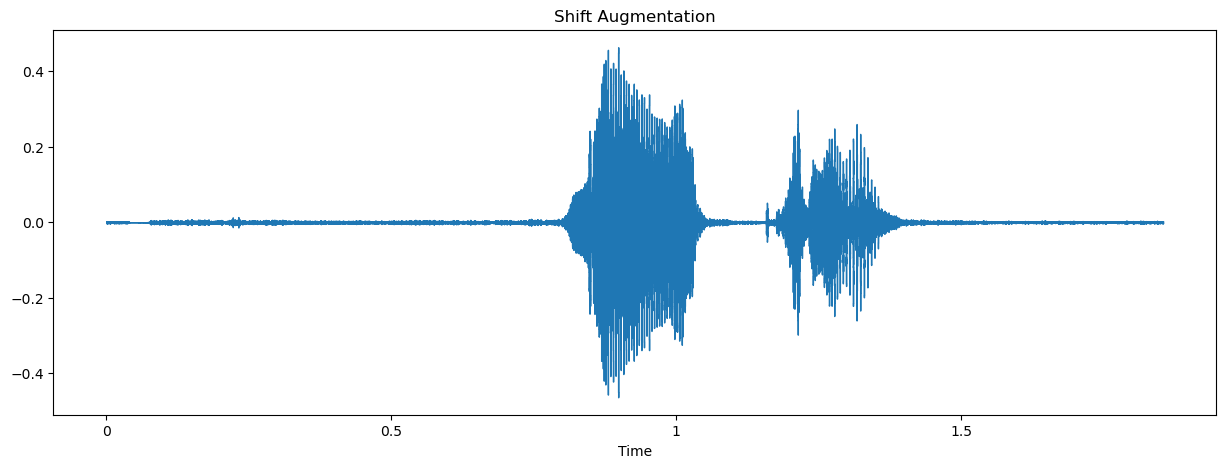

In [5]:
def shift(data):
    s_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, s_range)

x = shift(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
plt.title("Shift Augmentation")
plt.show()
ipd.Audio(x, rate=sampling_rate)

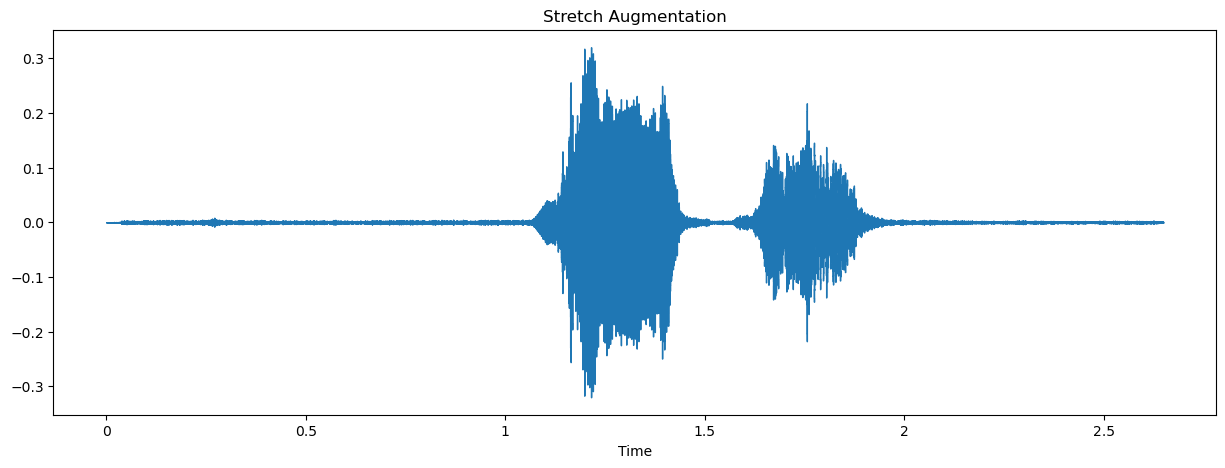

In [6]:
def stretch(data, rate=0.7):
    return librosa.effects.time_stretch(data, rate=rate)

x = stretch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
plt.title("Stretch Augmentation")
plt.show()
ipd.Audio(x, rate=sampling_rate)

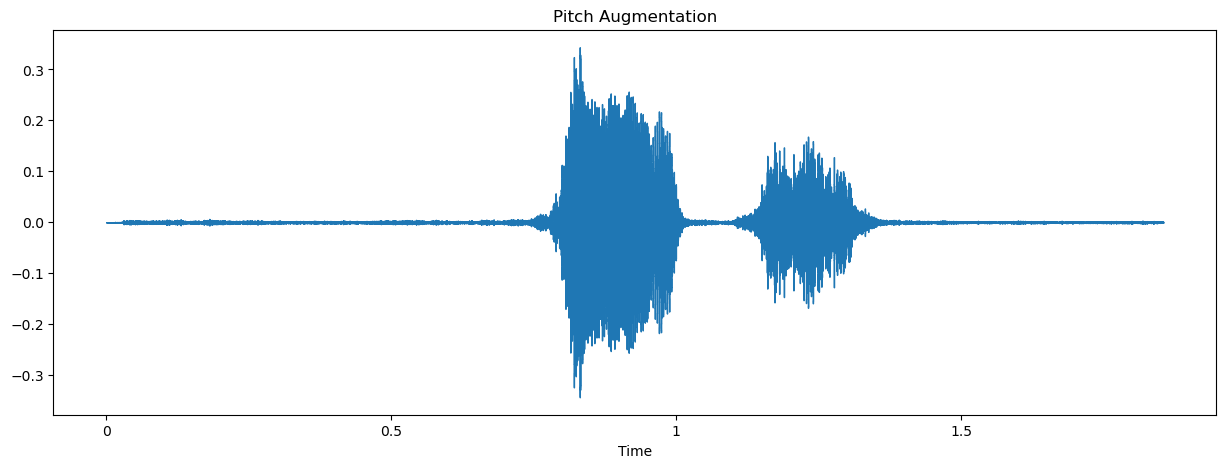

In [7]:
def pitch(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 
    data = librosa.effects.pitch_shift(y=data.astype('float64'), 
                                       sr=sample_rate, 
                                       n_steps=pitch_change, 
                                       bins_per_octave=bins_per_octave)
    return data


x = pitch(data, sampling_rate)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
plt.title("Pitch Augmentation")
plt.show()
ipd.Audio(x, rate=sampling_rate)


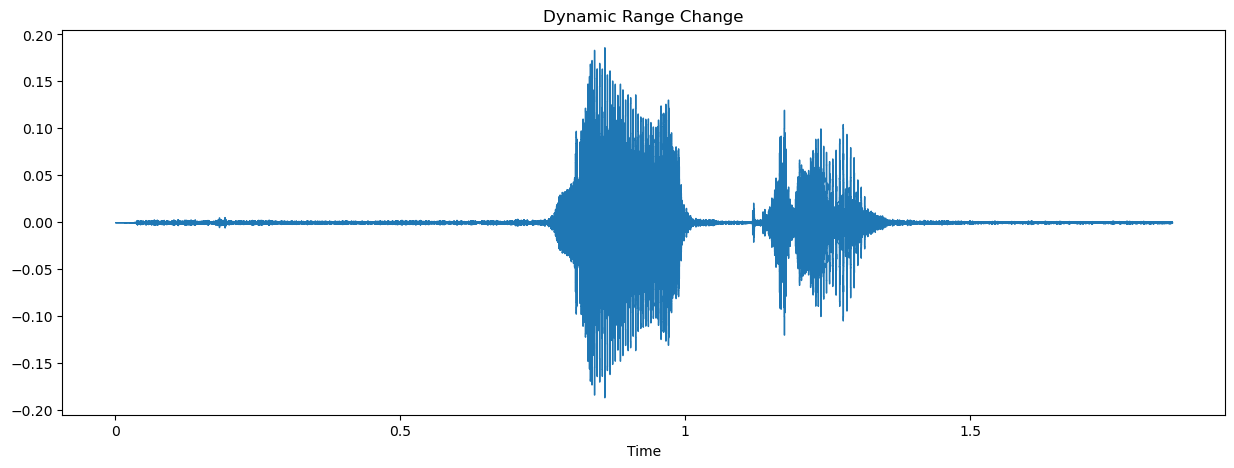

In [8]:
def dyn_change(data):
    dyn = np.random.uniform(low=0.3, high=2.0)
    return data * dyn

x = dyn_change(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
plt.title("Dynamic Range Change")
plt.show()
ipd.Audio(x, rate=sampling_rate)


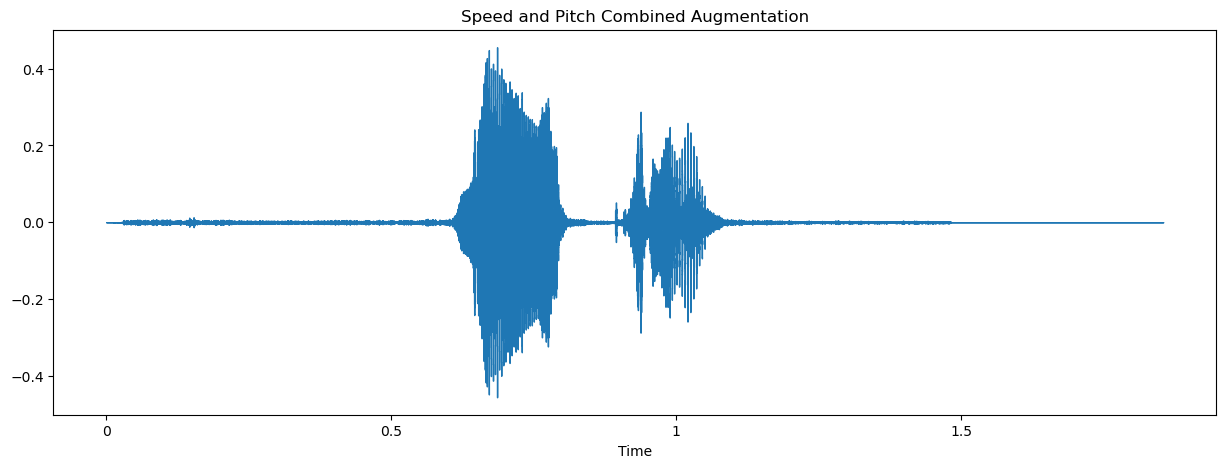

In [9]:
def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high=1)
    speed_fac = 1.2 / length_change
    tmp = np.interp(np.arange(0, len(data), speed_fac), np.arange(0, len(data)), data)
    minlen = min(len(data), len(tmp))
    data = np.zeros_like(data)
    data[0:minlen] = tmp[0:minlen]
    return data

x = speedNpitch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
plt.title("Speed and Pitch Combined Augmentation")
plt.show()
ipd.Audio(x, rate=sampling_rate)


In [10]:
# #Simpan data

# AUG_FUNCS = {
#     "noise": noise,
#     "shift": shift,
#     "stretch": stretch,
#     "pitch": lambda x: pitch(x, sampling_rate),
#     "dyn": dyn_change,
#     "speed": speedNpitch
# }

# NEW_PATH = "augdata2"
# os.makedirs(NEW_PATH, exist_ok=True)

# # Loop semua command dan file
# for command in COMMANDS:
#     folder_path = os.path.join(DATASET_PATH, command)
#     new_command_path = os.path.join(NEW_PATH, command)
#     os.makedirs(new_command_path, exist_ok=True)

#     for file in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, file)
#         data, sampling_rate = librosa.load(file_path, sr=None)
        
#         # Simpan audio original
#         original_filename = f"{os.path.splitext(file)[0]}_original.wav"
#         original_path = os.path.join(new_command_path, original_filename)
#         sf.write(original_path, data, sampling_rate)

#         for aug_name, func in AUG_FUNCS.items():
#             try:
#                 augmented_data = func(data)
#                 new_filename = f"{os.path.splitext(file)[0]}_{aug_name}.wav"
#                 new_file_path = os.path.join(new_command_path, new_filename)
#                 sf.write(new_file_path, augmented_data, sampling_rate)
#             except Exception as e:
#                 print(f"Gagal augmentasi {file} dengan {aug_name}: {e}")


In [11]:
import os
import random
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split

# Fungsi augmentasi
AUG_FUNCS = {
    "noise": noise,
    "shift": shift,
    "stretch": stretch,
    "pitch": lambda x: pitch(x, sampling_rate),
    "dyn": dyn_change,
    "speed": speedNpitch
}

# Path dataset dan folder simpanan baru
NEW_PATH = "augdata2"
TRAIN_PATH = os.path.join(NEW_PATH, "training")
VAL_PATH = os.path.join(NEW_PATH, "validation")
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)

# Loop setiap label
for command in COMMANDS:
    folder_path = os.path.join(DATASET_PATH, command)
    files = os.listdir(folder_path)

    # Bagi data menjadi training 40% dan validation 60%
    train_files, val_files = train_test_split(files, test_size=0.6, random_state=42)

    # Buat folder label di training dan validation
    train_label_path = os.path.join(TRAIN_PATH, command)
    val_label_path = os.path.join(VAL_PATH, command)
    os.makedirs(train_label_path, exist_ok=True)
    os.makedirs(val_label_path, exist_ok=True)

    # Simpan data validasi tanpa augmentasi
    for file in val_files:
        file_path = os.path.join(folder_path, file)
        data, sampling_rate = librosa.load(file_path, sr=None)
        save_path = os.path.join(val_label_path, f"{os.path.splitext(file)[0]}_original.wav")
        sf.write(save_path, data, sampling_rate)

    # Simpan data training dengan dan tanpa augmentasi
    for file in train_files:
        file_path = os.path.join(folder_path, file)
        data, sampling_rate = librosa.load(file_path, sr=None)

        # Simpan original
        original_path = os.path.join(train_label_path, f"{os.path.splitext(file)[0]}_original.wav")
        sf.write(original_path, data, sampling_rate)

        # Simpan data augmentasi
        for aug_name, func in AUG_FUNCS.items():
            try:
                augmented_data = func(data)
                new_filename = f"{os.path.splitext(file)[0]}_{aug_name}.wav"
                new_file_path = os.path.join(train_label_path, new_filename)
                sf.write(new_file_path, augmented_data, sampling_rate)
            except Exception as e:
                print(f"Gagal augmentasi {file} dengan {aug_name}: {e}")


In [13]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
